In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

import numpy as np
import matplotlib.pyplot as plt
import os
import sys

In [2]:
current_dir = os.getcwd()
src_path = os.path.join(current_dir, 'src')

if src_path not in sys.path:
    sys.path.append(src_path)

import viz
import grid
import cell
import FVM

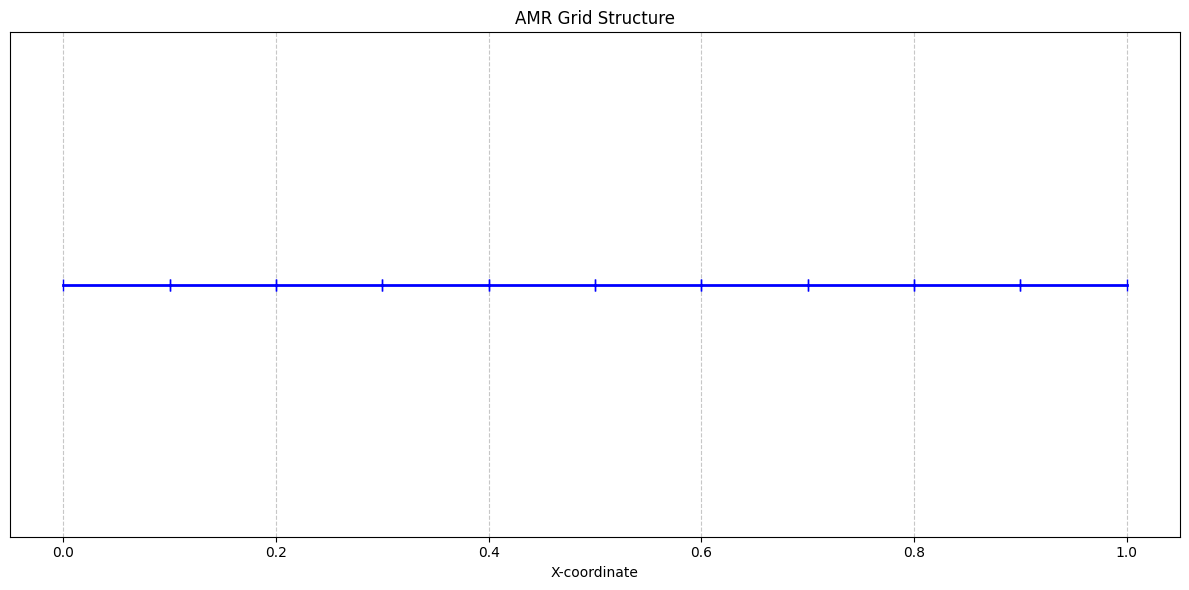

In [3]:
grid0 = grid.grid(1, 10)
viz.plot_amr_grid(grid0)

In [4]:
def init_grid(grid):
    """
    Initializes the primitive variables of the grid cells for the Sod Shock Tube problem.
    This function directly sets primitive values on cells.
    """
    active_cells = grid.get_all_active_cells()

    if not active_cells:
        print("No active cells found to initialize.")
        return

    cell_x_coords = np.array([cell.x for cell in active_cells])

    state_left = np.array([1.0, 0.0, 1.0])    # [density, velocity, pressure]
    state_right = np.array([0.125, 0.0, 0.1]) # [density, velocity, pressure]

    # Iterate through active cells and set their primitive variables directly
    for i, cell in enumerate(active_cells):
        if cell_x_coords[i] < 0.5:
            cell.prim = list(state_left)
        else:
            cell.prim = list(state_right)
    #  [rho_L, u_L, P_L, rho_R, u_R, P_R, gamma, x_diaphragm] for plotting analytical solution
    return [1, 0, 1, 0.125, 0, 0.1, FVM.get_gamma(), 0.5]

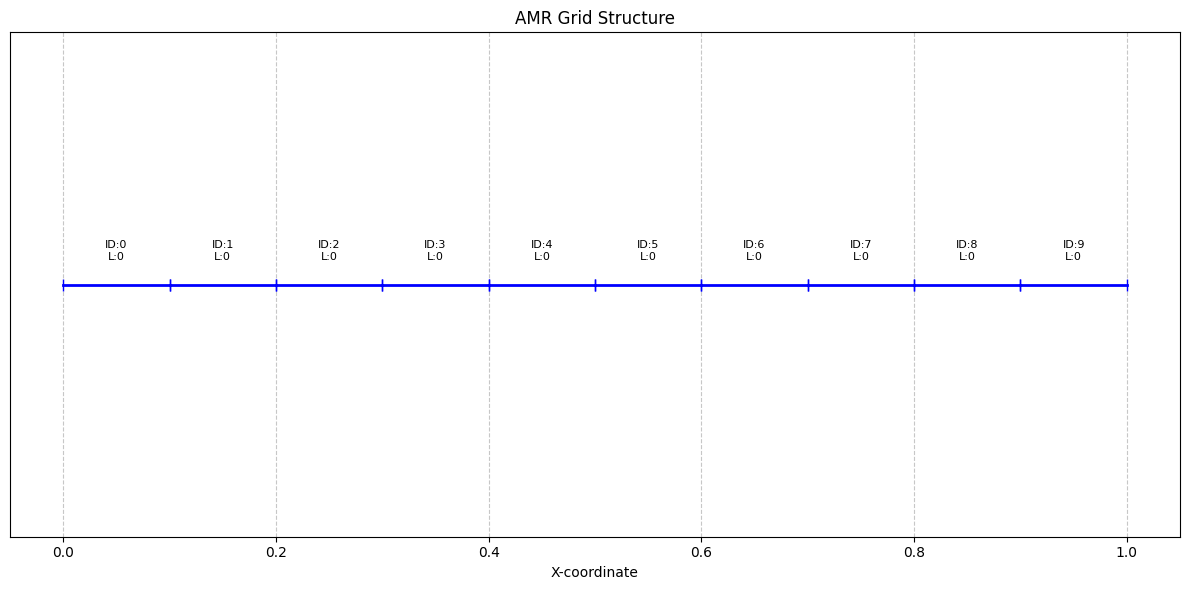

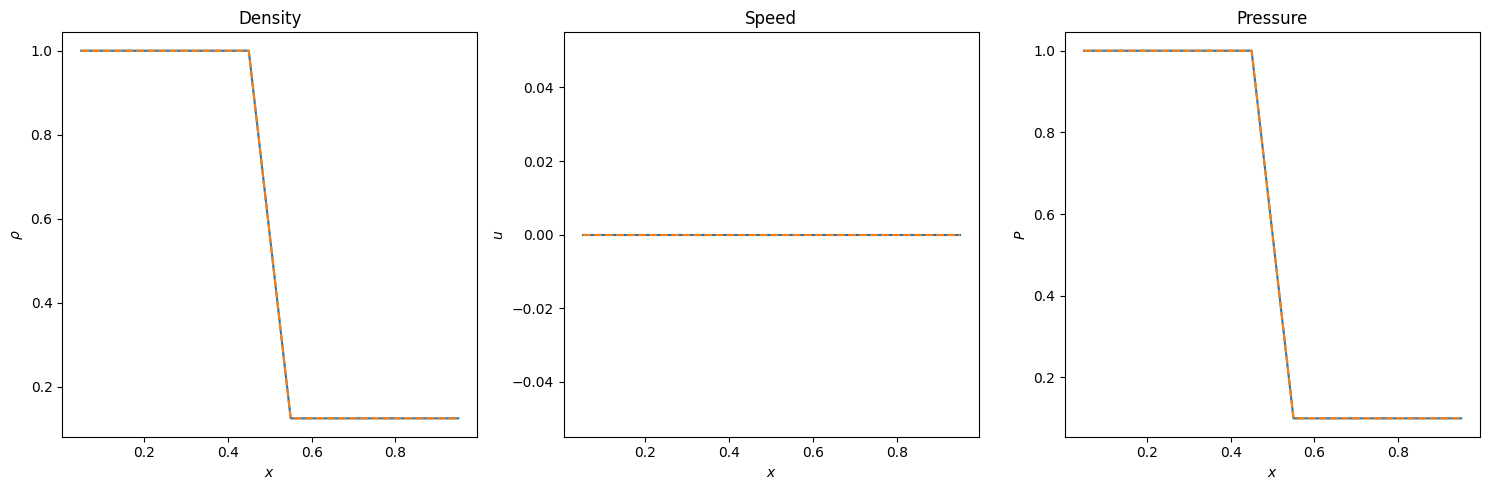

In [5]:
grid0 = grid.grid(1, 10)
init_con = init_grid(grid0)

viz.plot_amr_grid(grid0, label=True)
viz.plot_amr_value(grid0, analytic=init_con)

Solving Simulation: 100%|██████████| 0.2/0.2 [00:00<00:00,  4.29s/s]                 


FINISHED
187


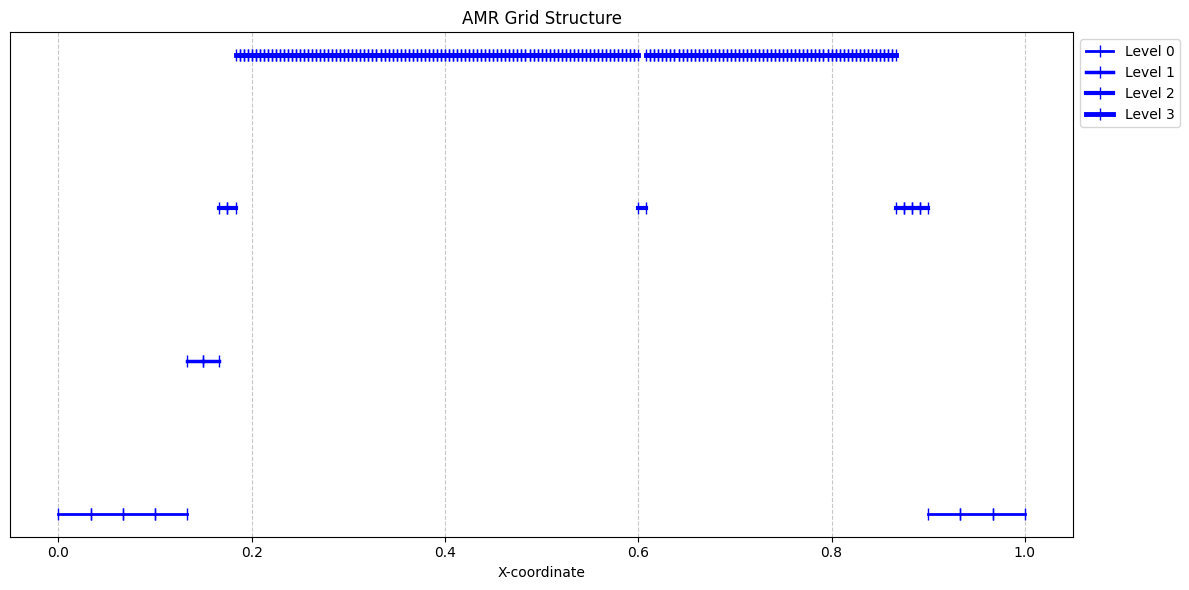

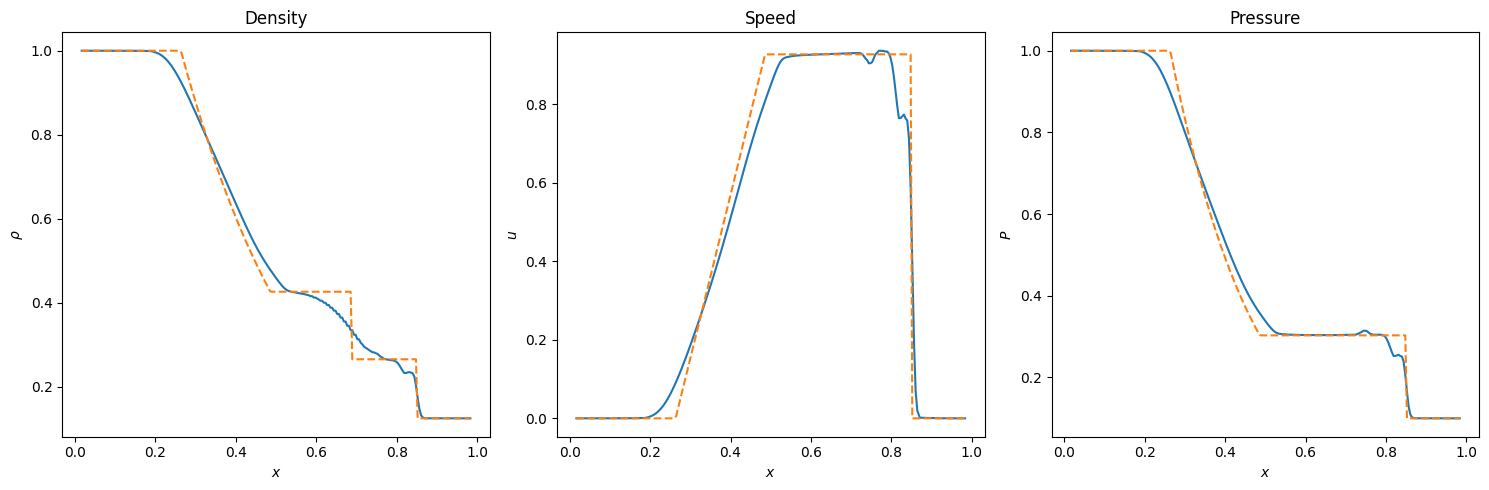

In [8]:
grid1 = grid.grid(L=1, N=30)
init_grid(grid1)
grid1_history = FVM.solve(FVM.HLL_flux, grid1, t_final=0.2, refine_epsilon=0.001, corase_epsilon=0.0001)
print(len(grid1_history))
viz.plot_amr_grid(grid1)
viz.plot_amr_value(grid1, analytic=init_con)
#viz.animate(grid1_history, 'plot/test.gif')

Preparing animation with 187 frames for display...


 99%|█████████▉| 186/187 [00:37<00:00,  4.78it/s]

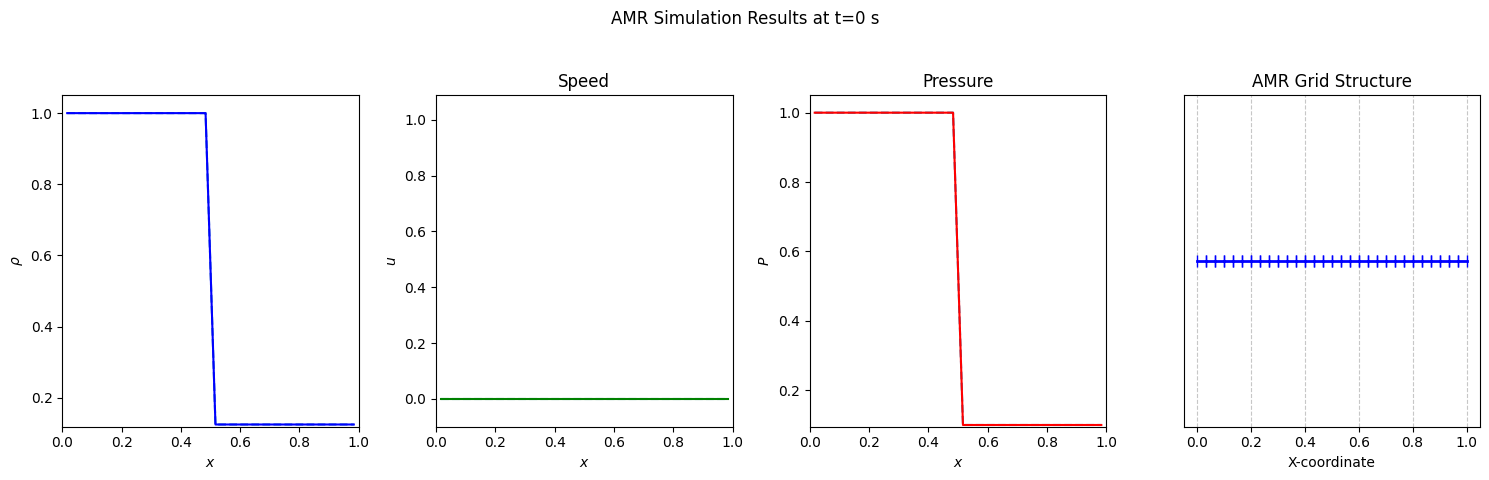

In [9]:
viz.animate(grid1_history, 'plot/test2.gif', fps=len(grid1_history)/5, analytic=init_con)

 99%|█████████▉| 186/187 [00:41<00:00,  4.47it/s]
Solving Simulation: 100%|██████████| 0.2/0.2 [00:01<00:00,  5.29s/s]                


FINISHED
200


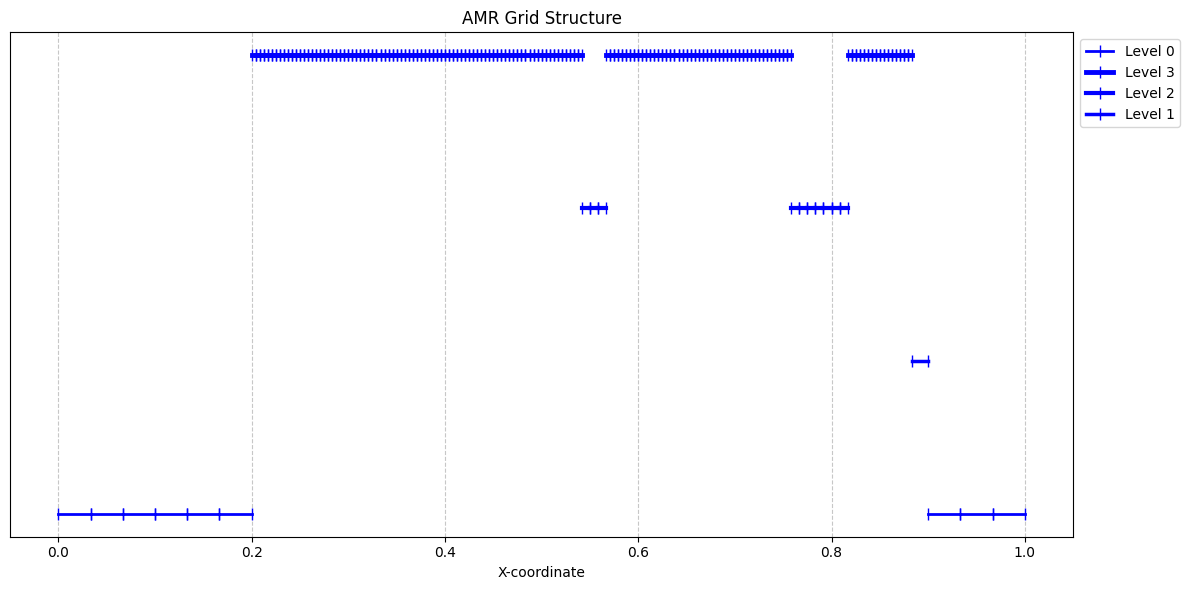

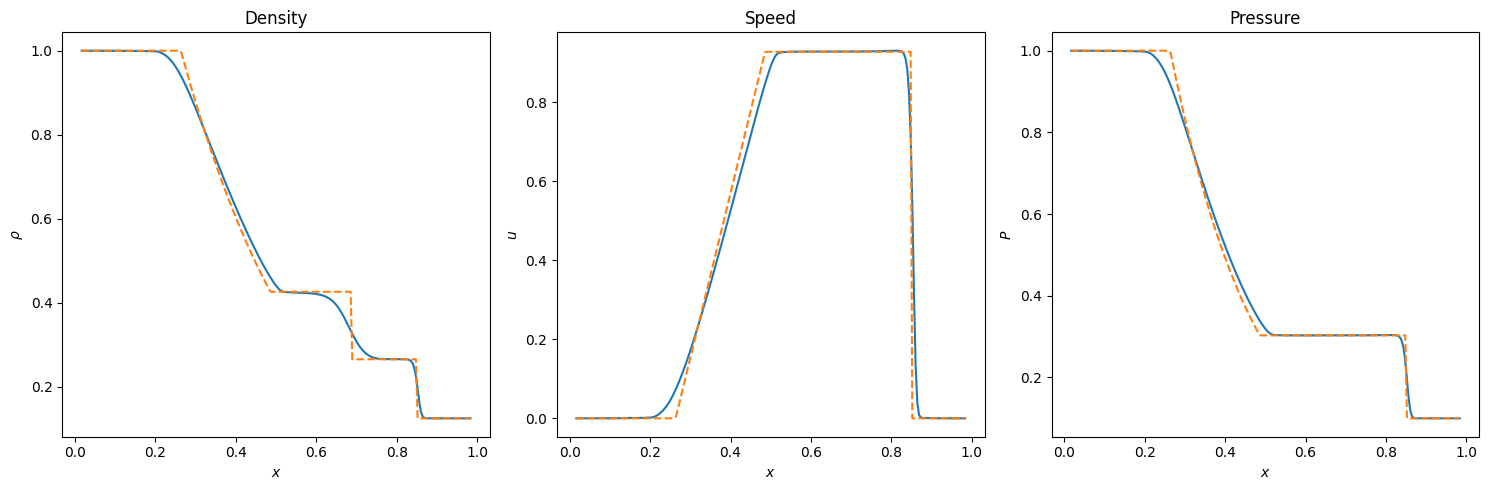

In [10]:
grid2 = grid.grid(L=1, N=30)
init_grid(grid2)
grid2_history = FVM.new_solve(FVM.HLL_flux, grid2, t_final=0.2, epsilon=0.0001)
print(len(grid2_history))
viz.plot_amr_grid(grid2)
viz.plot_amr_value(grid2, analytic=init_con)

Preparing animation with 200 frames for display...


100%|█████████▉| 199/200 [00:39<00:00,  5.04it/s]

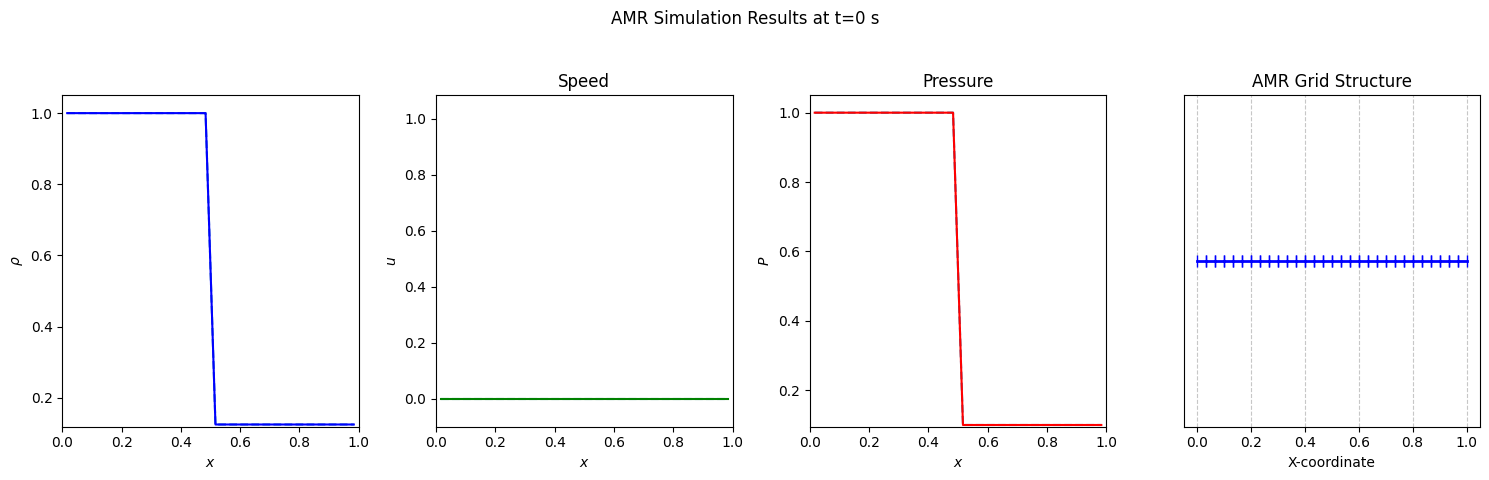

In [11]:
viz.animate(grid2_history, 'plot/test3.gif', fps=len(grid2_history)/5, analytic=init_con)

# Comparison

In [12]:
def MSE(data1, data2):
    data = np.sum((data1 - data2) ** 2)
    return data / len(data1)

In [13]:
import analytical
import time

def calc_MSE(history):
    grid_cells = history[-1].get_all_active_cells()

    X = np.array([c.x for c in grid_cells])
    t = history[-1].t
    grid_solution = np.array([c.prim for c in grid_cells])
    analytic_solution = analytical.get_sod_solution(X, t, *init_con)

    return MSE(grid_solution.T, analytic_solution)

print(f"Old Method MSE: {calc_MSE(grid1_history)}, New Method MSE: {calc_MSE(grid2_history)}")

Old Method MSE: 0.3798301902727399, New Method MSE: 0.2440697119126833


In [14]:
old_MSE = []
new_MSE = []
N_history = []
old_time = []
new_time = []
old_history = []
new_history = []

for n in range(10, 110, 10):
    print(f"Current step: {n}")

    # old method
    test_grid = grid.grid(L=1, N=n)
    init_grid(test_grid)
    start_time = time.time()
    test_grid_history = FVM.solve(FVM.HLL_flux, test_grid, t_final=0.2, refine_epsilon=0.001, corase_epsilon=0.0001)
    end_time = time.time()

    old_MSE.append(calc_MSE(test_grid_history))
    old_time.append(end_time - start_time)
    old_history.append(test_grid_history)

    # new method
    init_grid(test_grid)
    start_time = time.time()
    test_grid_history = FVM.new_solve(FVM.HLL_flux, test_grid, t_final=0.2, epsilon=0.0001)
    end_time = time.time()

    new_MSE.append(calc_MSE(test_grid_history))
    new_time.append(end_time - start_time)
    new_history.append(test_grid_history)
    N_history.append(n)

Current step: 10


Solving Simulation: 100%|██████████| 0.2/0.2 [00:00<00:00,  1.51s/s]                


FINISHED


Solving Simulation: 100%|██████████| 0.2/0.2 [00:00<00:00,  1.06s/s]                


FINISHED
Current step: 20


100%|█████████▉| 199/200 [00:44<00:00,  4.43it/s]
Solving Simulation: 100%|██████████| 0.2/0.2 [00:00<00:00,  3.02s/s]              


FINISHED


Solving Simulation: 100%|██████████| 0.2/0.2 [00:00<00:00,  3.31s/s]                


FINISHED
Current step: 30


Solving Simulation: 100%|██████████| 0.2/0.2 [00:01<00:00,  5.45s/s]                


FINISHED


Solving Simulation: 100%|██████████| 0.2/0.2 [00:01<00:00,  7.86s/s]                 


FINISHED
Current step: 40


Solving Simulation: 100%|██████████| 0.2/0.2 [00:01<00:00,  8.86s/s]                


FINISHED


Solving Simulation: 100%|██████████| 0.2/0.2 [00:02<00:00, 12.89s/s]                 


FINISHED
Current step: 50


Solving Simulation: 100%|██████████| 0.2/0.2 [00:03<00:00, 15.08s/s]                 


FINISHED


Solving Simulation: 100%|██████████| 0.2/0.2 [00:04<00:00, 20.31s/s]                 


FINISHED
Current step: 60


Solving Simulation: 100%|██████████| 0.2/0.2 [00:03<00:00, 18.04s/s]                 


FINISHED


Solving Simulation: 100%|██████████| 0.2/0.2 [00:05<00:00, 27.02s/s]                  


FINISHED
Current step: 70


Solving Simulation: 100%|██████████| 0.2/0.2 [00:04<00:00, 24.51s/s]                 


FINISHED


Solving Simulation: 100%|██████████| 0.2/0.2 [00:07<00:00, 38.57s/s]                 


FINISHED
Current step: 80


Solving Simulation: 100%|██████████| 0.2/0.2 [00:05<00:00, 27.80s/s]                 


FINISHED


Solving Simulation: 100%|██████████| 0.2/0.2 [00:10<00:00, 50.44s/s]                    


FINISHED
Current step: 90


Solving Simulation: 100%|██████████| 0.2/0.2 [00:11<00:00, 55.47s/s]                 


FINISHED


Solving Simulation: 100%|██████████| 0.2/0.2 [00:15<00:00, 77.69s/s]                  


FINISHED
Current step: 100


Solving Simulation: 100%|██████████| 0.2/0.2 [00:11<00:00, 58.32s/s]                 


FINISHED


Solving Simulation: 100%|██████████| 0.2/0.2 [00:13<00:00, 65.45s/s]                  

FINISHED


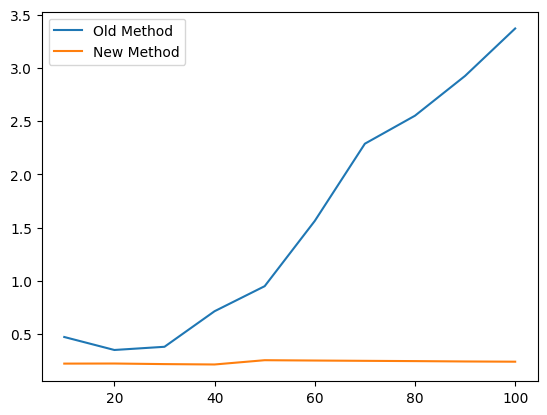

In [15]:
plt.plot(N_history, old_MSE, label='Old Method')
plt.plot(N_history, new_MSE, label='New Method')
plt.legend()

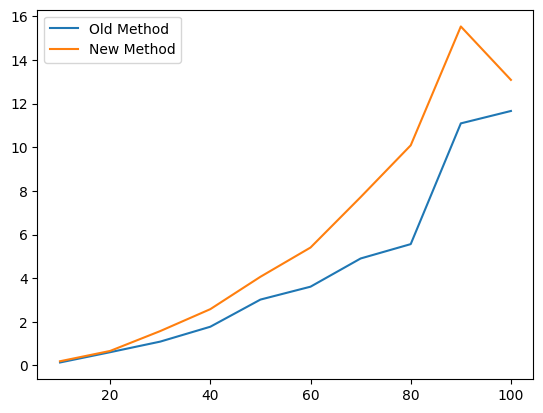

In [16]:
plt.plot(N_history, old_time, label='Old Method')
plt.plot(N_history, new_time, label='New Method')
plt.legend()

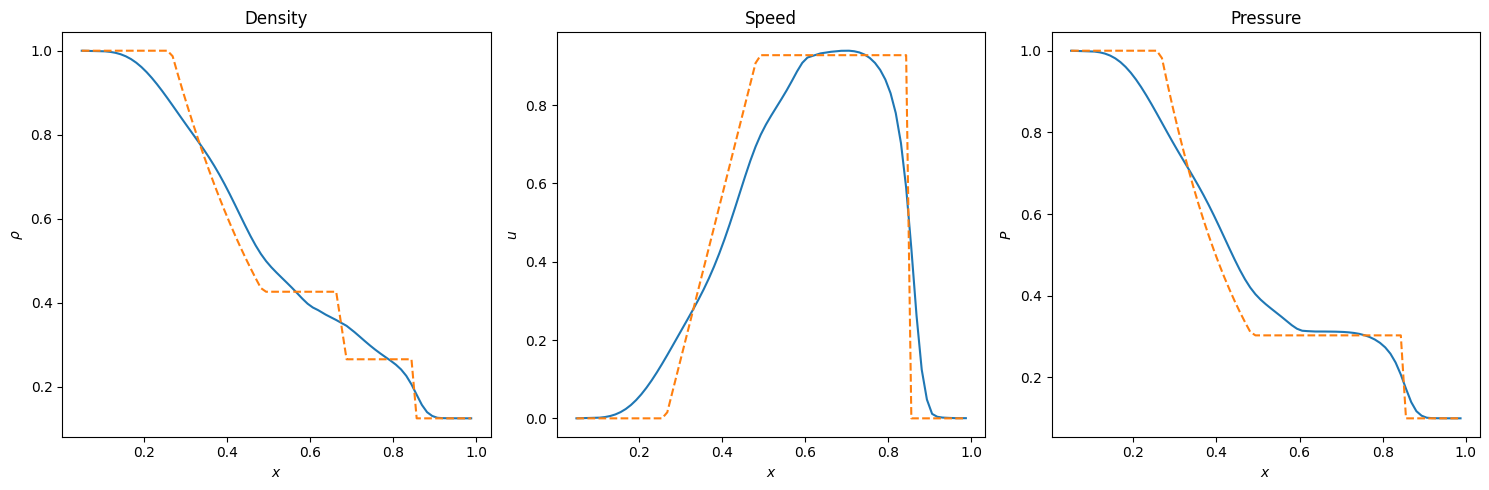

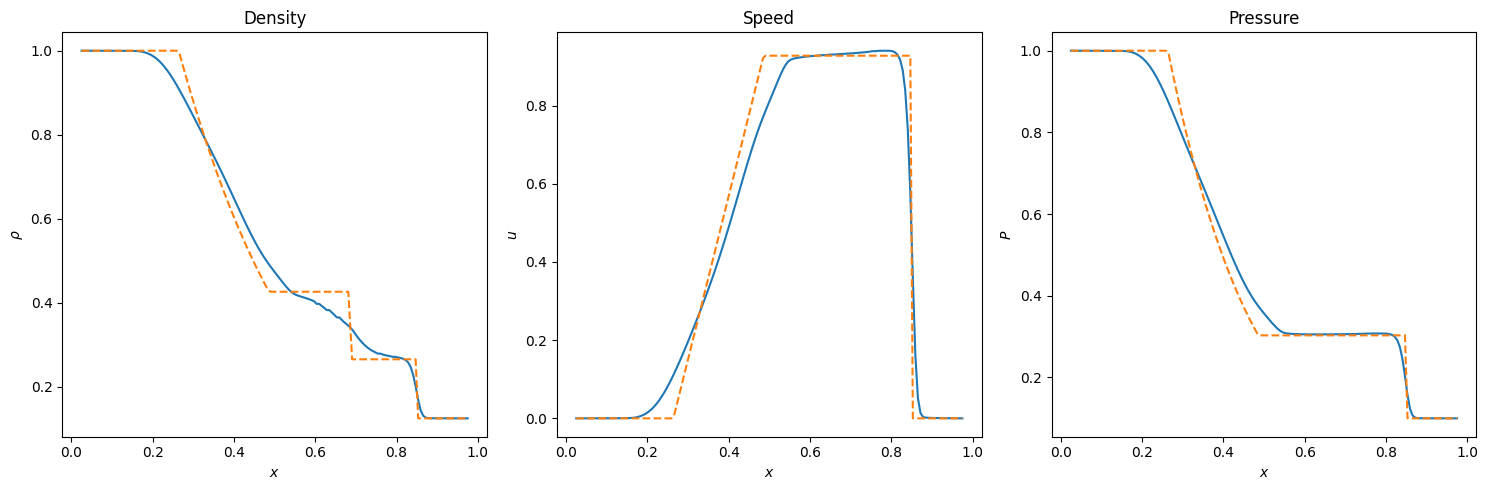

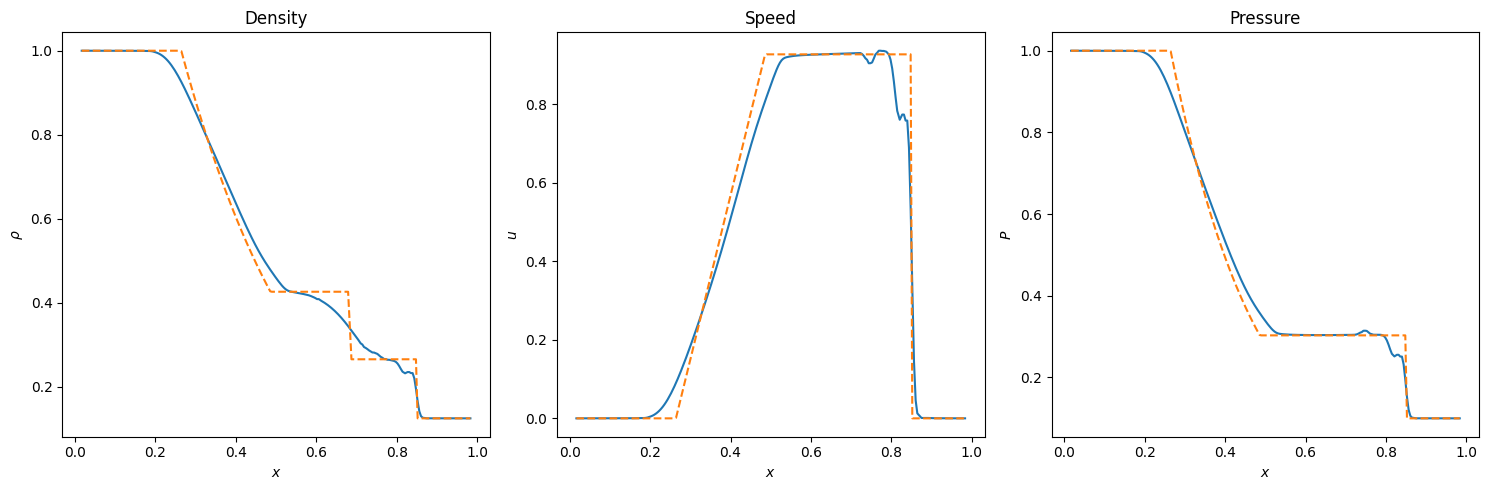

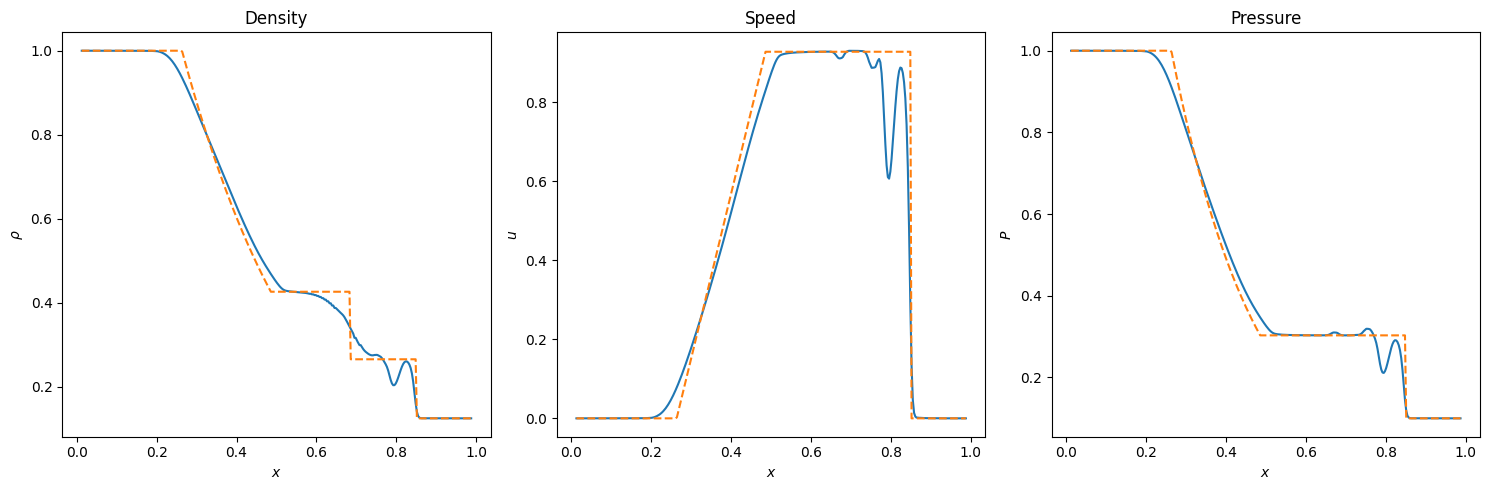

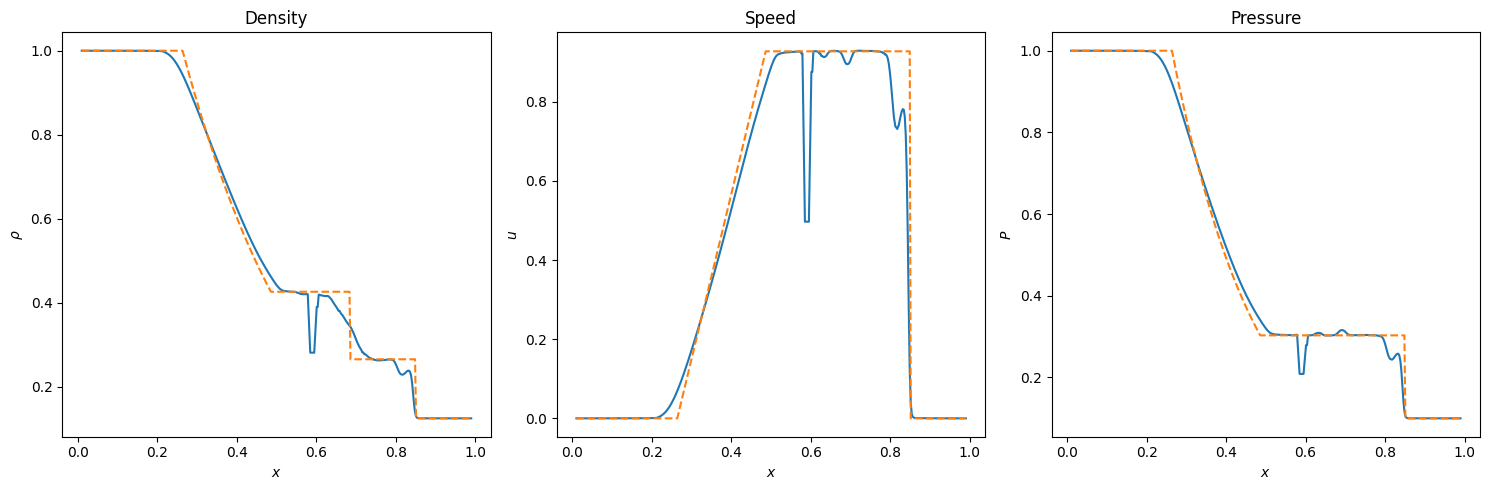

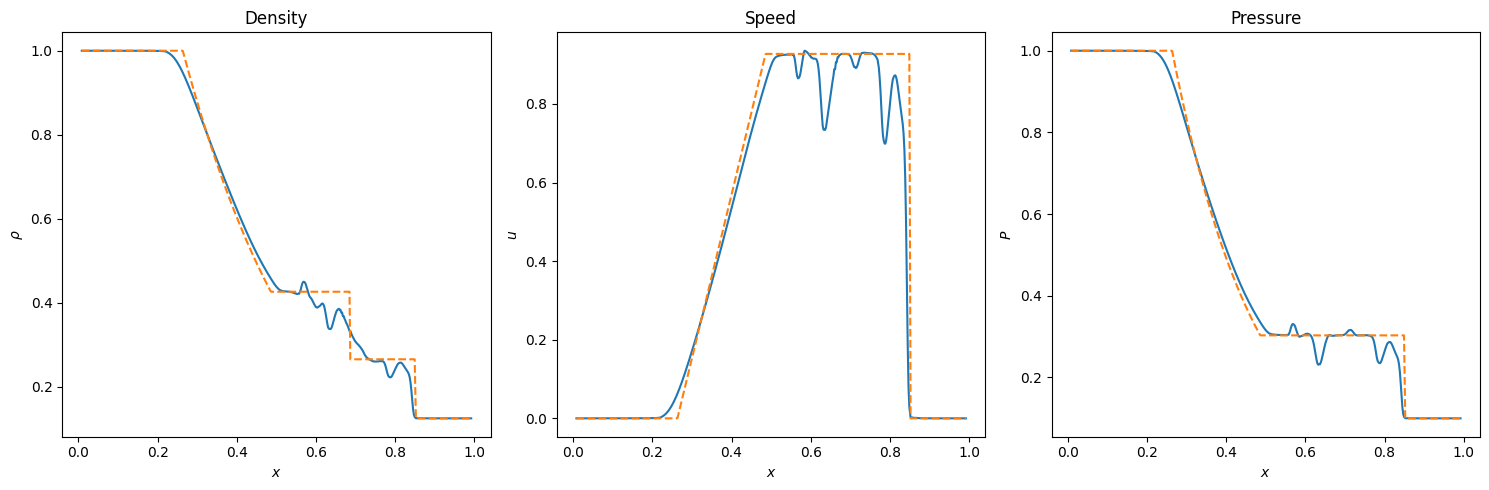

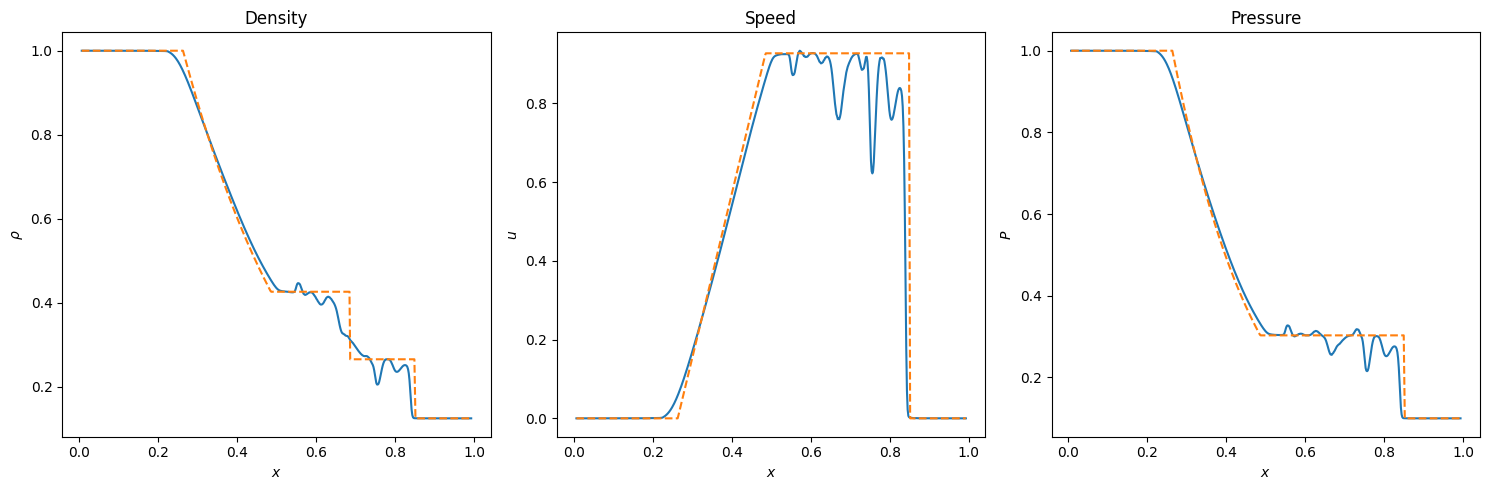

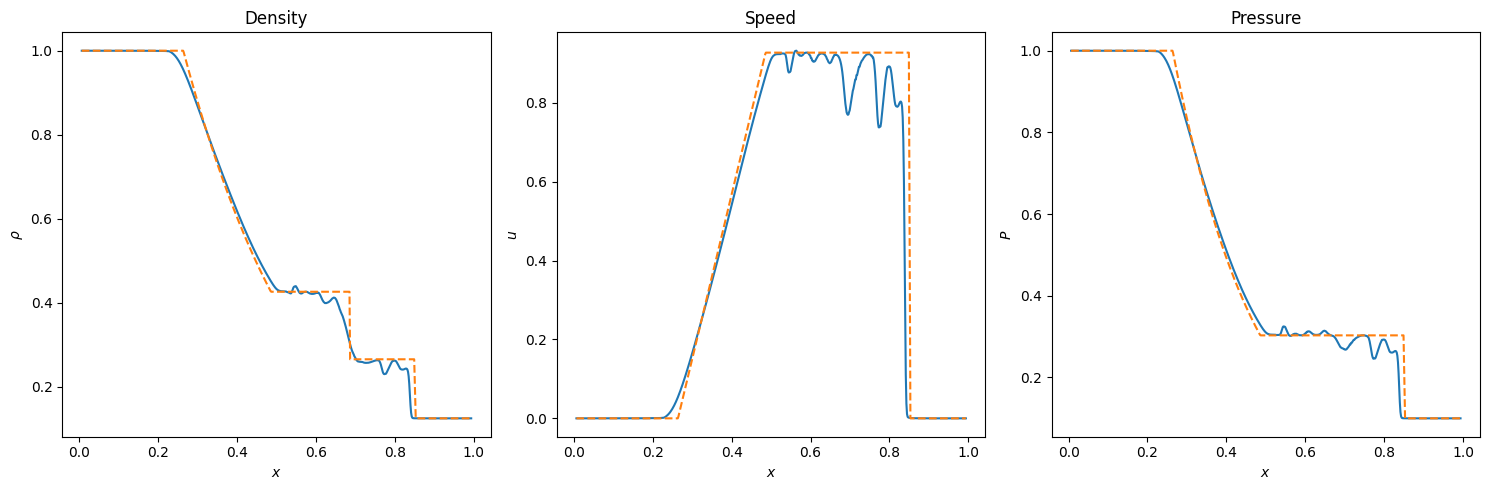

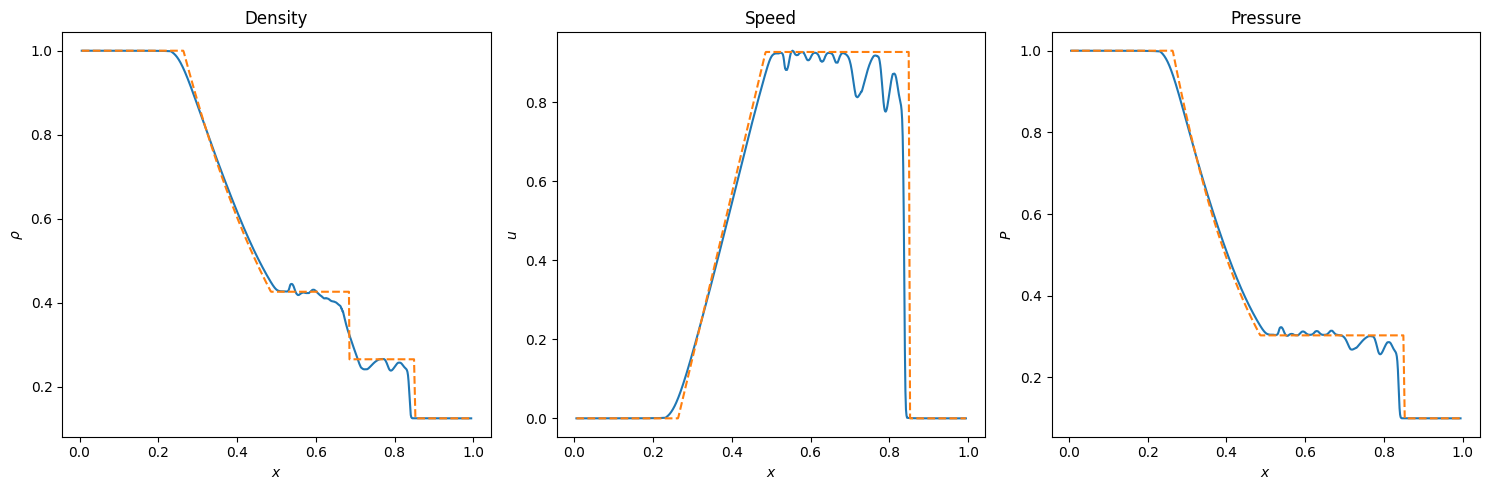

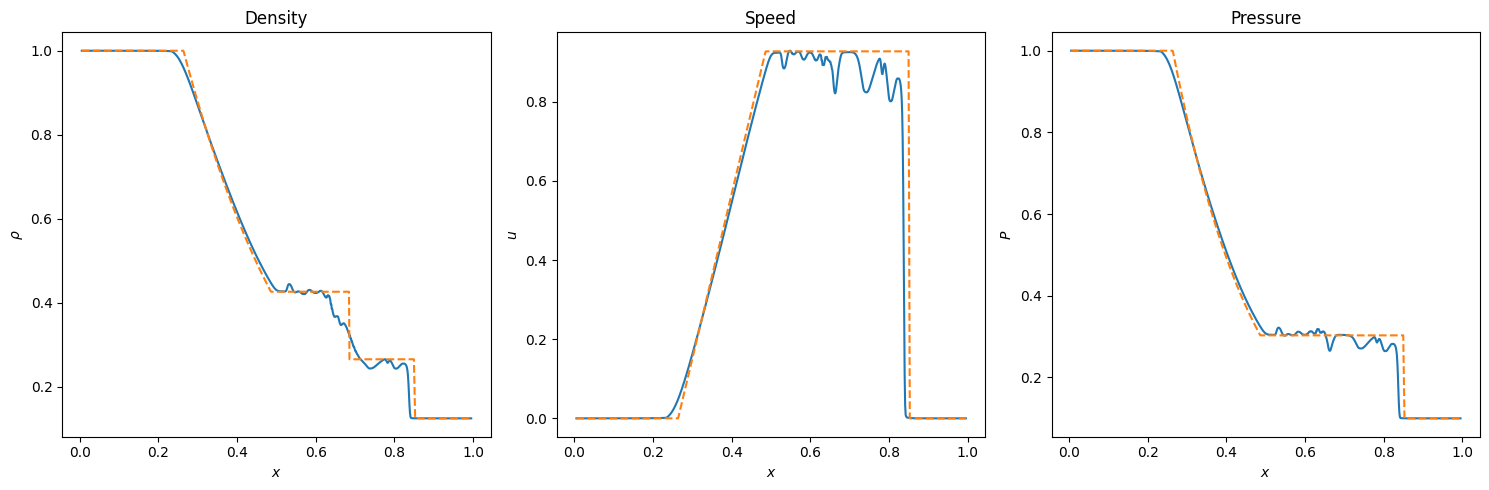

In [25]:
for n in range(len(old_history)):
    viz.plot_amr_value(old_history[n][-1], analytic=init_con)

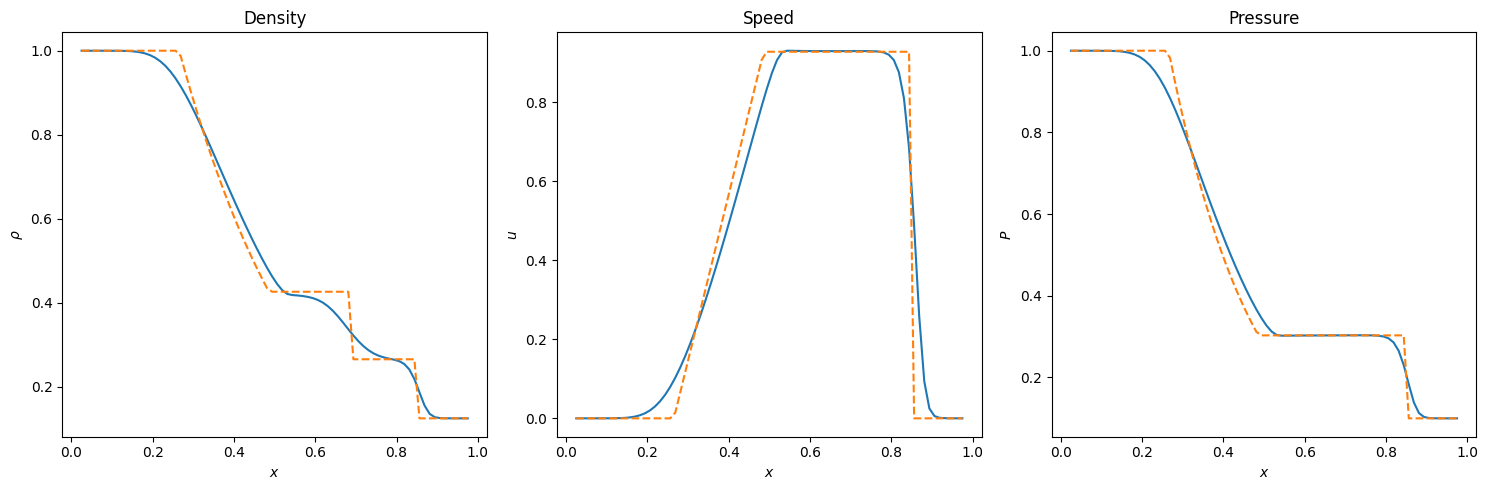

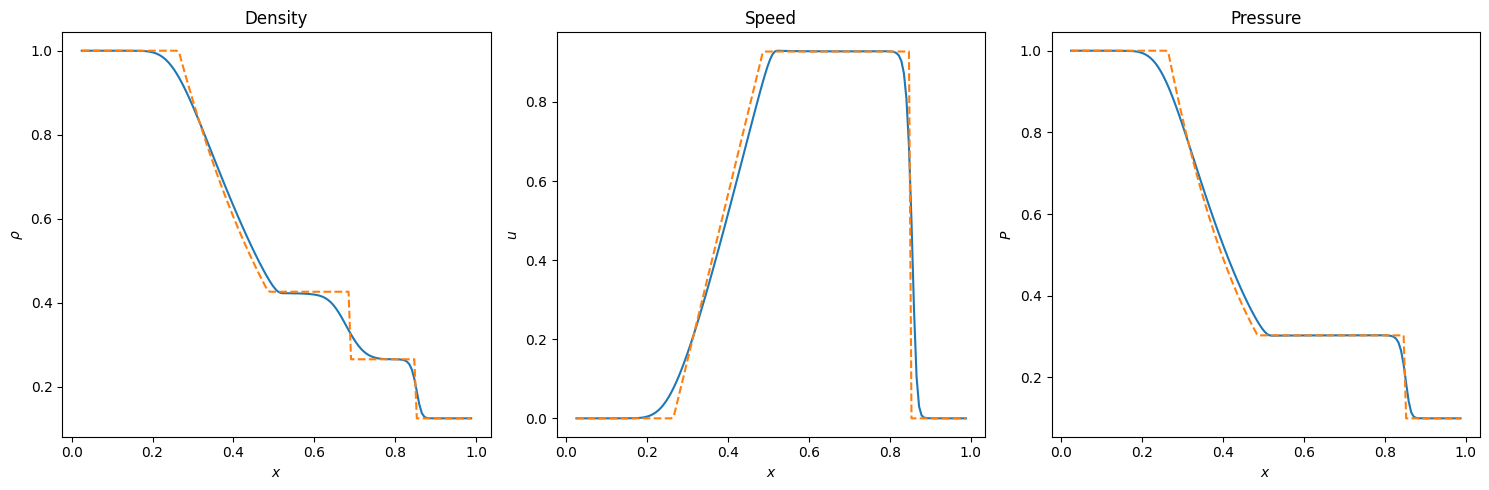

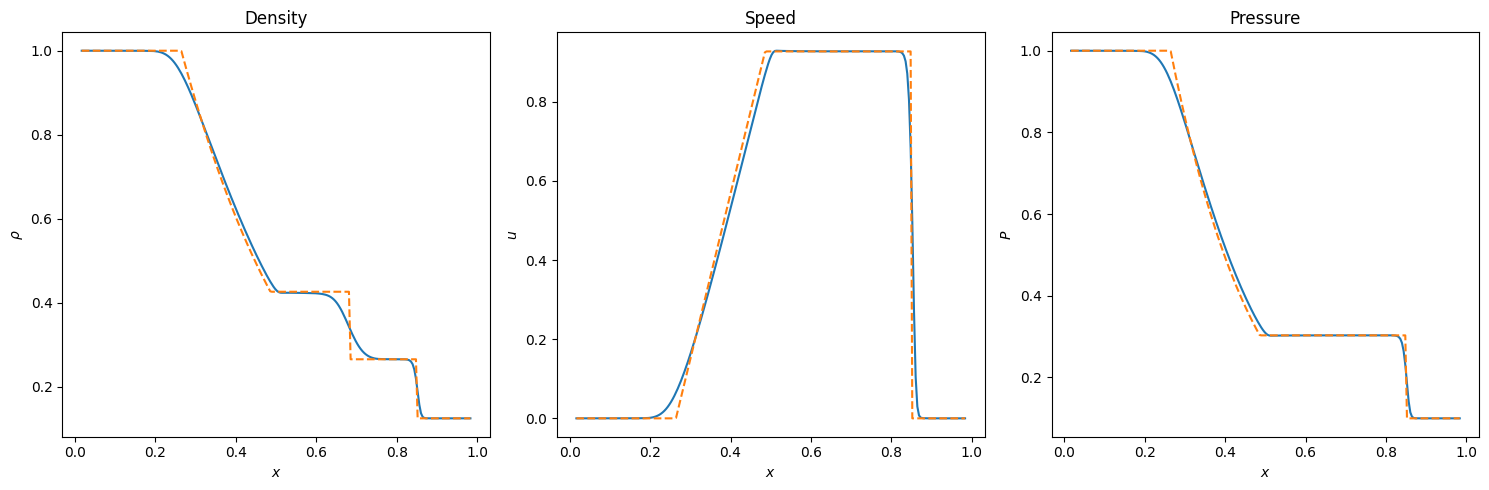

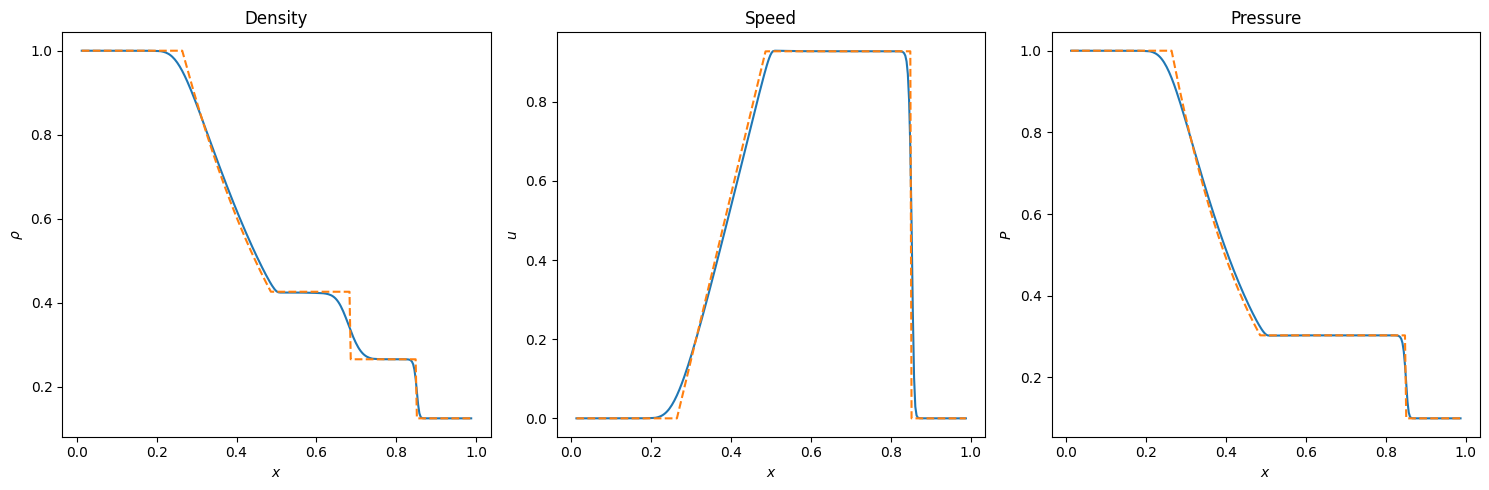

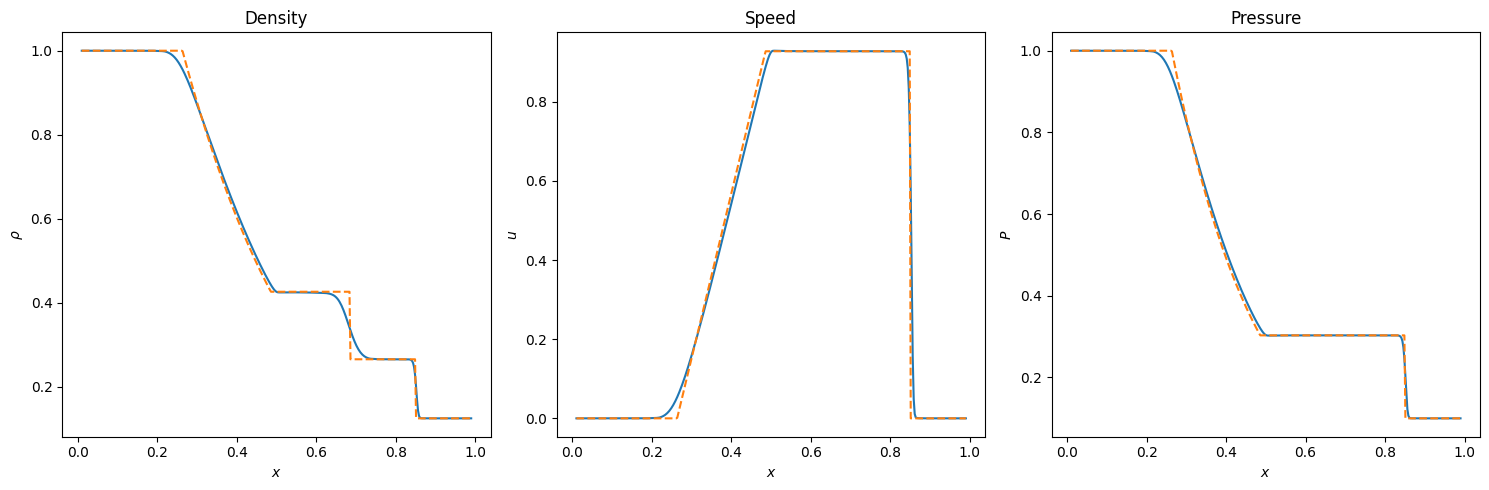

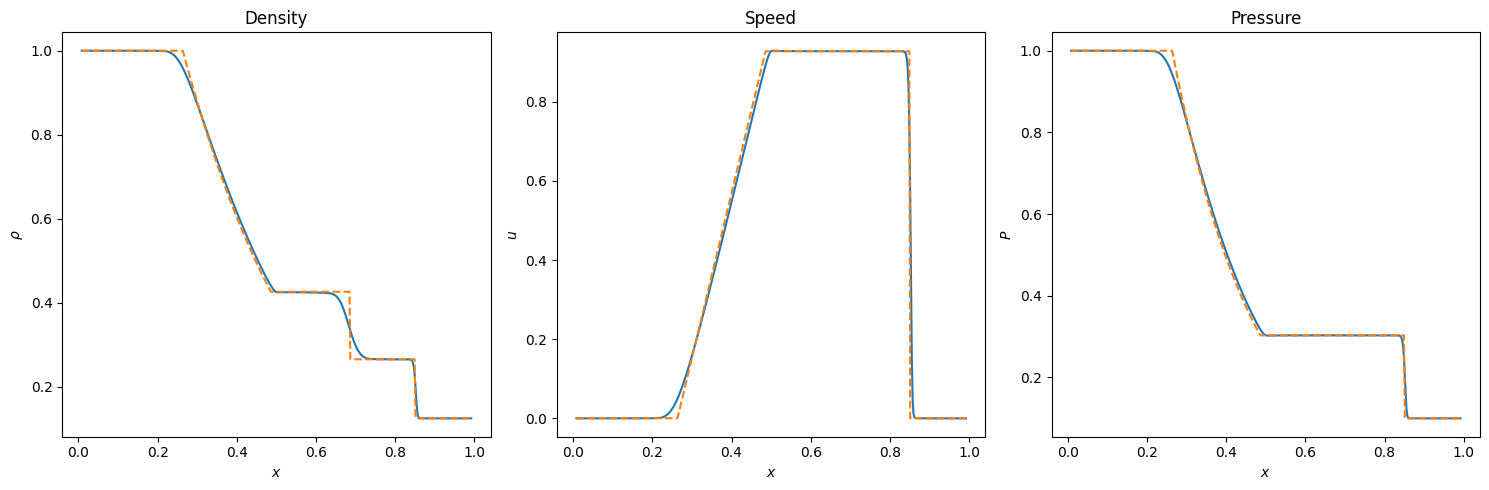

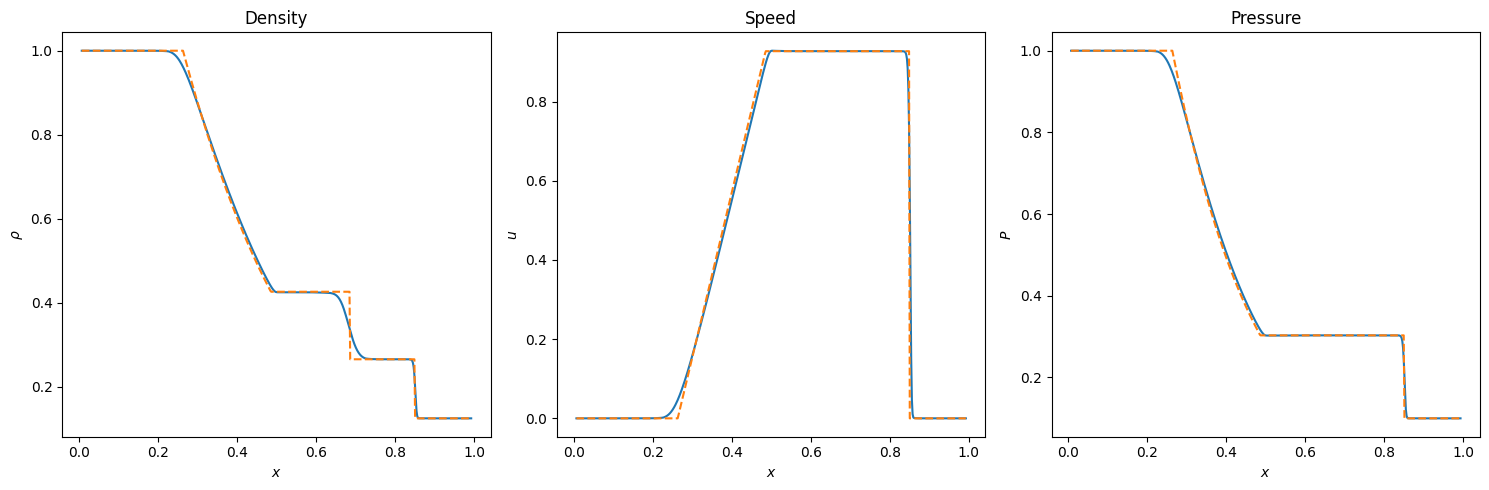

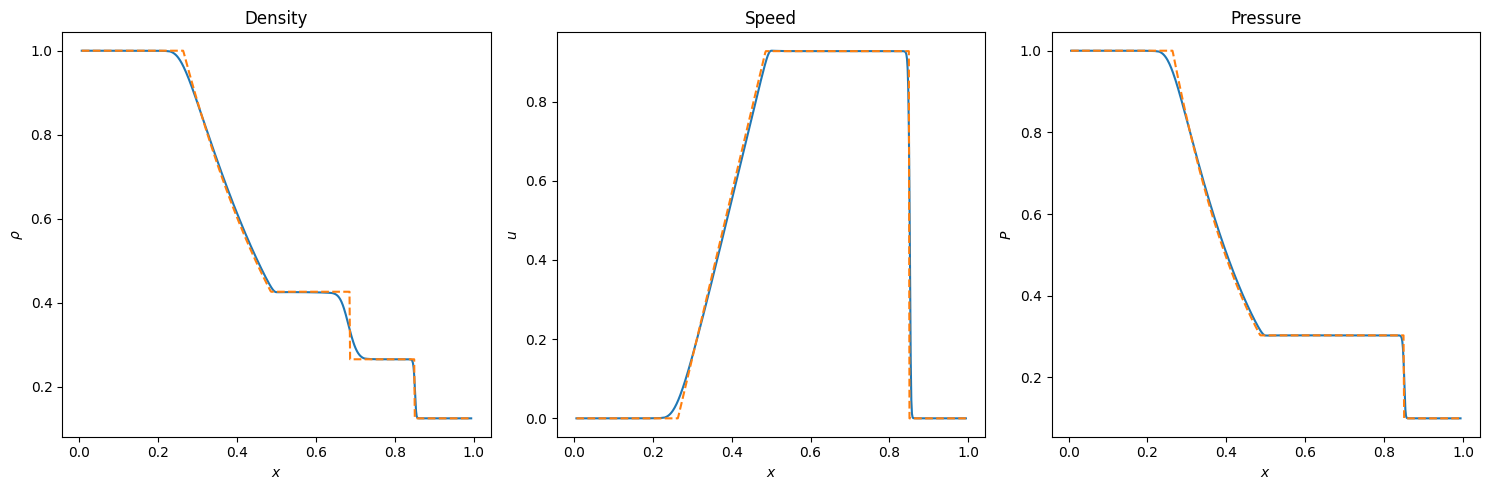

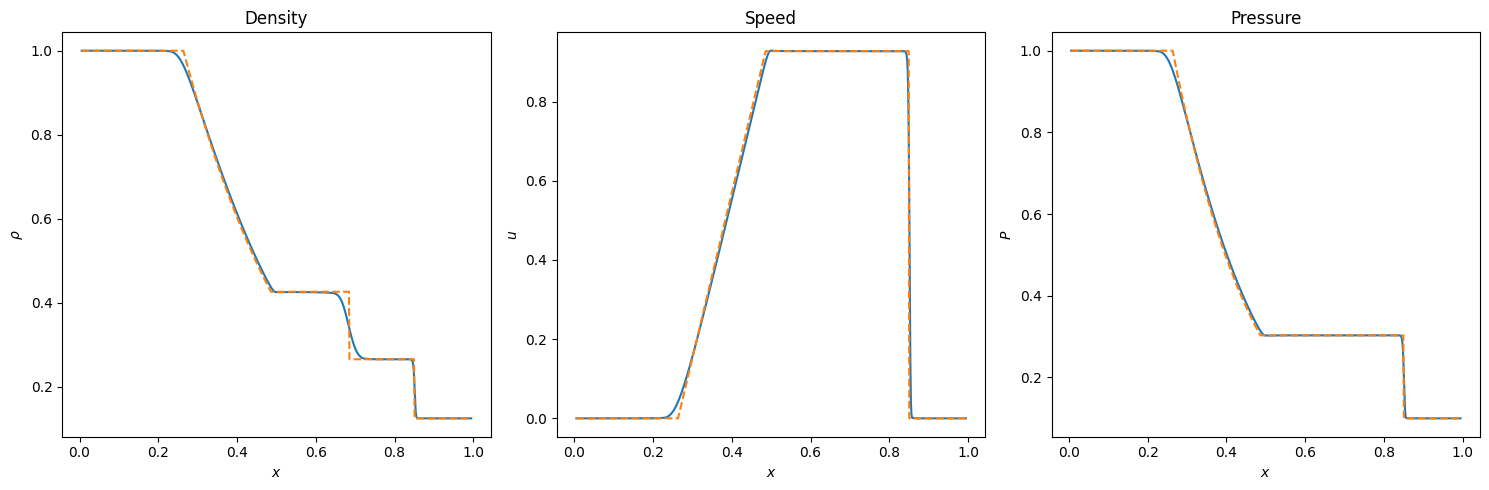

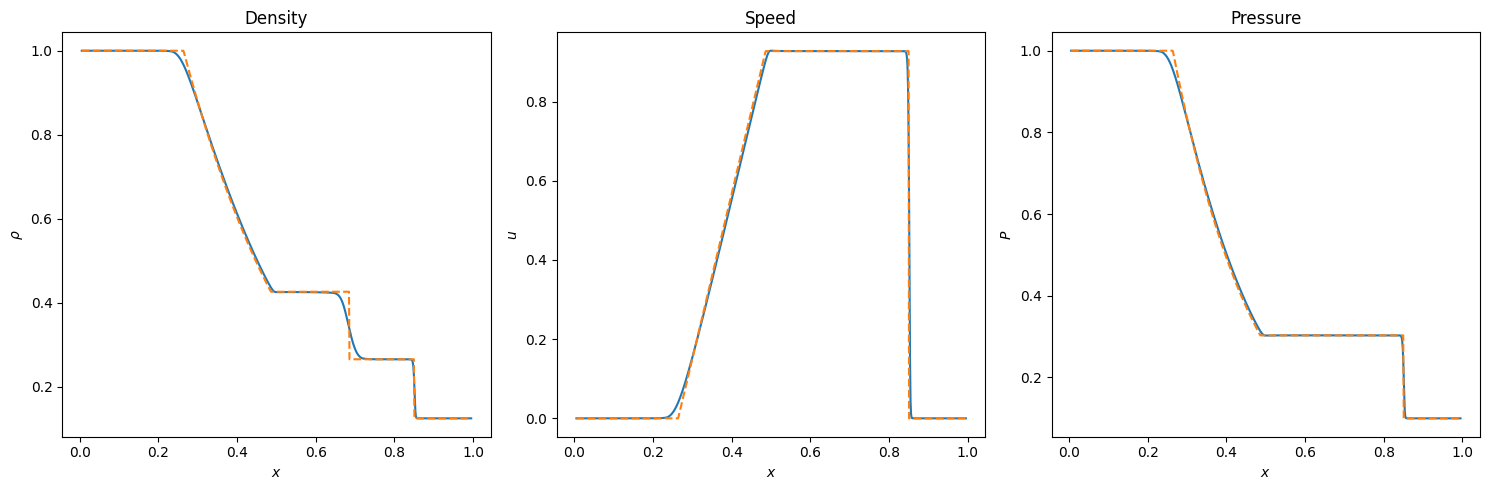

In [26]:
for n in range(len(old_history)):
    viz.plot_amr_value(new_history[n][-1], analytic=init_con)